In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2021-11-15 10:32:01--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  82.8MB/s    in 0.7s    

2021-11-15 10:32:02 (82.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

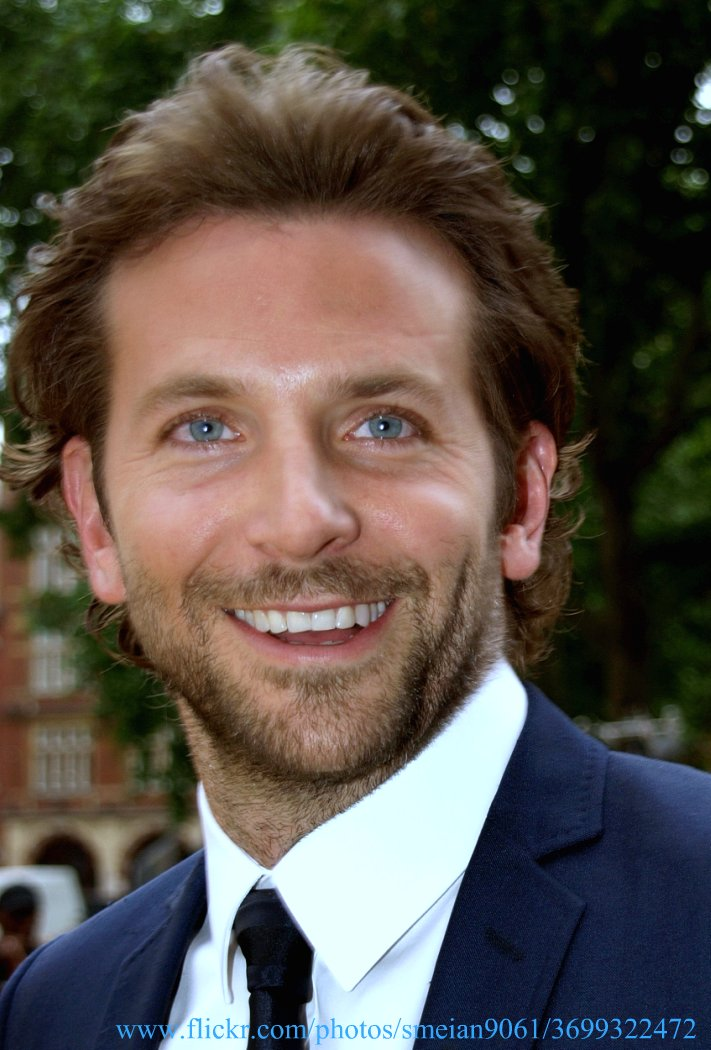

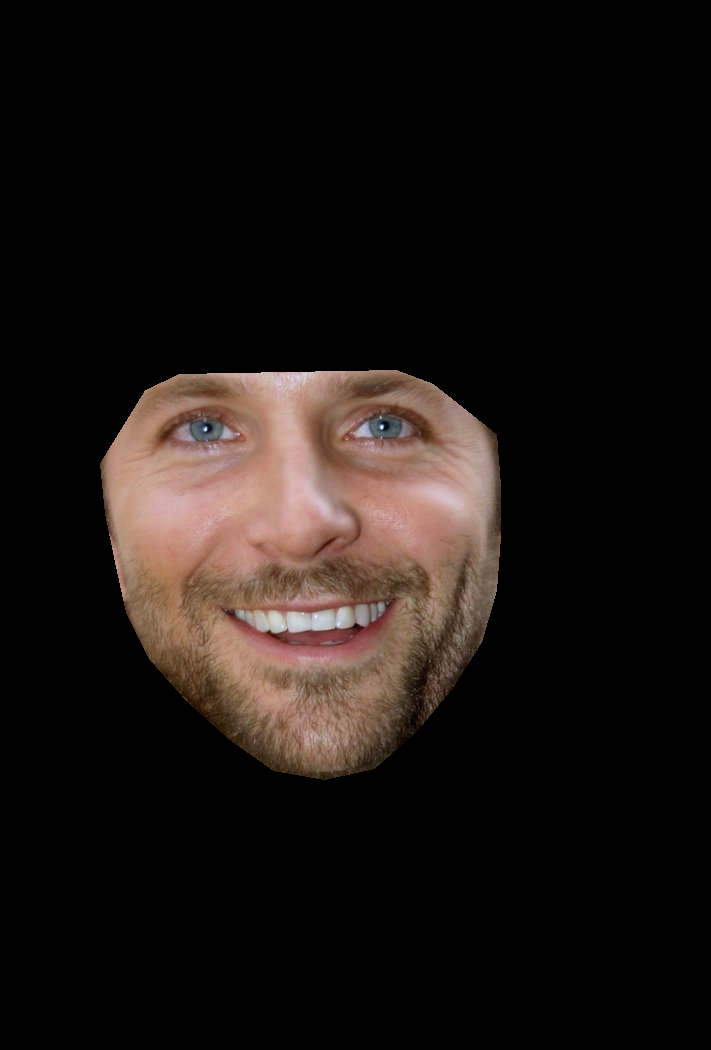

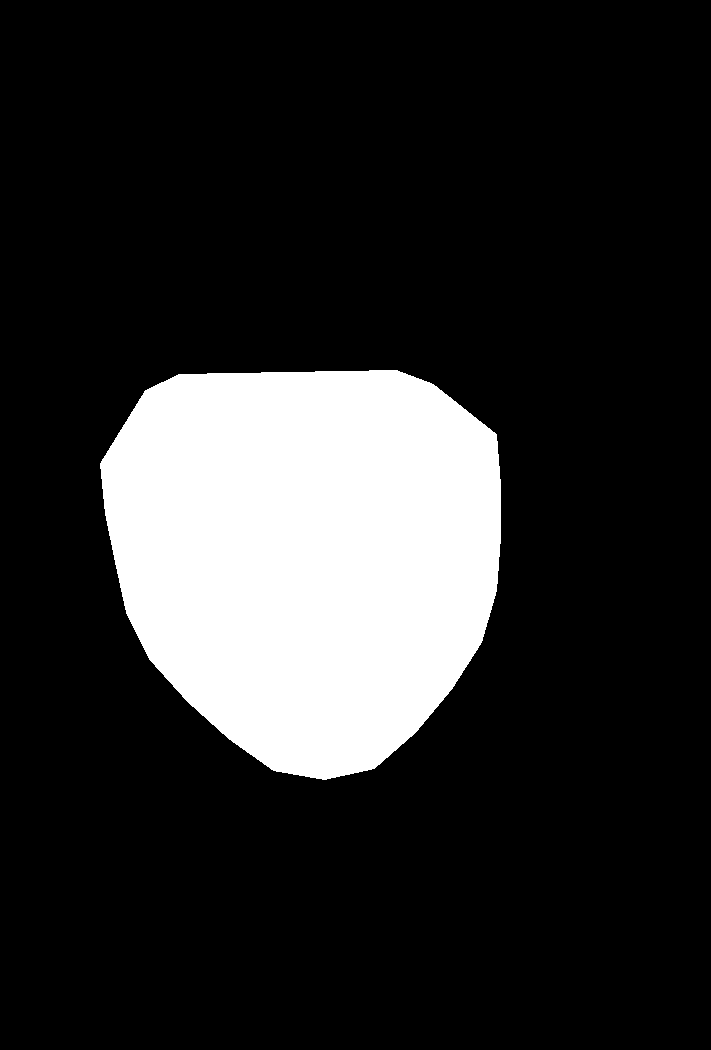

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import dlib

img = cv2.imread("bradley_cooper.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

        #cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    #cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)





cv2_imshow(img)
cv2_imshow(face_image_1)
cv2_imshow(mask)


In [ ]:
# Photo face swapping using opencv 
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import dlib
import time

def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index


img = cv2.imread("bradley_cooper.jpg")
img2 = cv2.imread("jim_carrey.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)

img2_new_face = np.zeros_like(img2)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

        # cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    # cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)




# Face 2
faces2 = detector(img2_gray)
for face in faces2:
	landmarks = predictor(img2_gray, face)
	landmarks_points2 = []
	for n in range(0, 68):
		x = landmarks.part(n).x
		y = landmarks.part(n).y
		landmarks_points2.append((x, y))

		#cv2.circle(img2, (x, y), 3, (0, 255, 0), -1)
	points2 = np.array(landmarks_points2, np.int32)
	convexhull2 = cv2.convexHull(points2)

# Triangulation of both faces
for triangle_index in indexes_triangles:
	# Triangulation of the first face
	tr1_pt1 = landmarks_points[triangle_index[0]]
	tr1_pt2 = landmarks_points[triangle_index[1]]
	tr1_pt3 = landmarks_points[triangle_index[2]]
	triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

	rect1 = cv2.boundingRect(triangle1)
	(x, y, w, h) = rect1
	cropped_triangle = img[y: y + h, x: x + w]
	cropped_tr1_mask = np.zeros((h, w), np.uint8)

	points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
					  [tr1_pt2[0] - x, tr1_pt2[1] - y],
					  [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

	cv2.fillConvexPoly(cropped_tr1_mask, points, 255)
	cropped_triangle = cv2.bitwise_and(cropped_triangle, cropped_triangle,
									   mask=cropped_tr1_mask)


	# cv2.line(img, tr1_pt1, tr1_pt2, (0, 0, 255), 2)
	# cv2.line(img, tr1_pt3, tr1_pt2, (0, 0, 255), 2)
	# cv2.line(img, tr1_pt1, tr1_pt3, (0, 0, 255), 2)

	# Triangulation of second face
	tr2_pt1 = landmarks_points2[triangle_index[0]]
	tr2_pt2 = landmarks_points2[triangle_index[1]]
	tr2_pt3 = landmarks_points2[triangle_index[2]]
	triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

	rect2 = cv2.boundingRect(triangle2)
	(x, y, w, h) = rect2
	cropped_triangle2 = img2[y: y + h, x: x + w]
	cropped_tr2_mask = np.zeros((h, w), np.uint8)

	points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
					   [tr2_pt2[0] - x, tr2_pt2[1] - y],
					   [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

	cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)
	cropped_triangle2 = cv2.bitwise_and(cropped_triangle2, cropped_triangle2,
									   mask=cropped_tr2_mask)

	# cv2.line(img2, tr2_pt1, tr2_pt2, (0, 0, 255), 2)
	# cv2.line(img2, tr2_pt3, tr2_pt2, (0, 0, 255), 2)
	# cv2.line(img2, tr2_pt1, tr2_pt3, (0, 0, 255), 2)

	# Warp triangles
	points = np.float32(points)
	points2 = np.float32(points2)
	M = cv2.getAffineTransform(points, points2)
	warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
	
	# Reconstructing destination face
	img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
	img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
	img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

img2_head_noface = np.zeros_like(img)

img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)


cv2_imshow(img)
cv2_imshow(img2)
cv2_imshow(result)



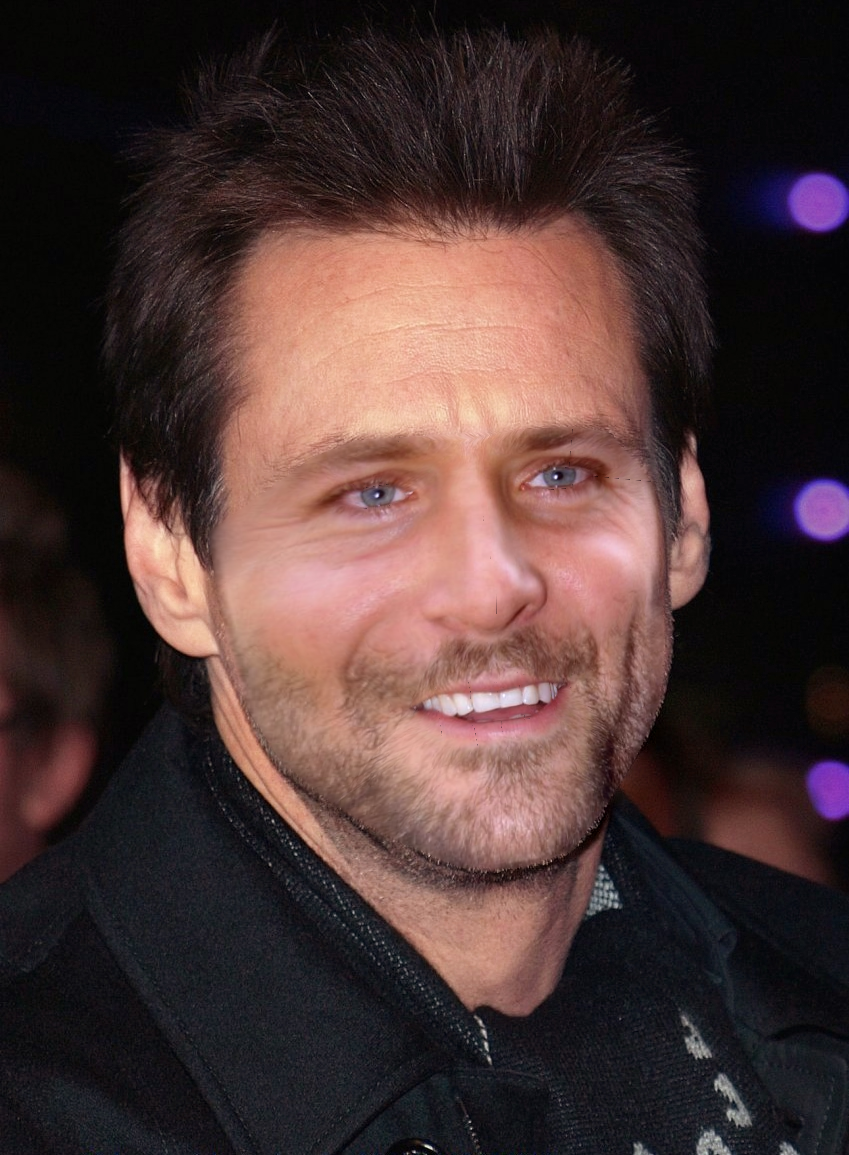

In [ ]:
# swapping faces using opencv 
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import dlib
import time


def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index


img = cv2.imread("bradley_cooper.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = cv2.imread("jim_carrey.jpg")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)




# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))



    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    # cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)



# Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area



# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

cv2_imshow(seamlessclone)


****Now creating my own Deepfake video****

In [ ]:
!pip install ffmpy &> /dev/null
!git init -q .
!git remote add origin https://github.com/AliaksandrSiarohin/first-order-model
!git pull -q origin master
!git clone -q https://github.com/graphemecluster/first-order-model-demo demo

In [ ]:
import IPython.display
import PIL.Image
import cv2
import imageio
import io
import ipywidgets
import numpy
import os.path
import requests
import skimage.transform
import warnings
from base64 import b64encode
from demo import load_checkpoints, make_animation
from ffmpy import FFmpeg
from google.colab import files, output
from IPython.display import HTML, Javascript
from skimage import img_as_ubyte
warnings.filterwarnings("ignore")
os.makedirs("user", exist_ok=True)

display(HTML("""
<style>
.widget-box > * {
	flex-shrink: 0;
}
.widget-tab {
	min-width: 0;
	flex: 1 1 auto;
}
.widget-tab .p-TabBar-tabLabel {
	font-size: 15px;
}
.widget-upload {
	background-color: tan;
}
.widget-button {
	font-size: 18px;
	width: 160px;
	height: 34px;
	line-height: 34px;
}
.widget-dropdown {
	width: 250px;
}
.widget-checkbox {
    width: 650px;
}
.widget-checkbox + .widget-checkbox {
    margin-top: -6px;
}
.input-widget .output_html {
	text-align: center;
	width: 266px;
	height: 266px;
	line-height: 266px;
	color: lightgray;
	font-size: 72px;
}
div.stream {
	display: none;
}
.title {
	font-size: 20px;
	font-weight: bold;
	margin: 12px 0 6px 0;
}
.warning {
	display: none;
	color: red;
	margin-left: 10px;
}
.warn {
	display: initial;
}
.resource {
	cursor: pointer;
	border: 1px solid gray;
	margin: 5px;
	width: 160px;
	height: 160px;
	min-width: 160px;
	min-height: 160px;
	max-width: 160px;
	max-height: 160px;
	-webkit-box-sizing: initial;
	box-sizing: initial;
}
.resource:hover {
	border: 6px solid crimson;
	margin: 0;
}
.selected {
	border: 6px solid seagreen;
	margin: 0;
}
.input-widget {
	width: 266px;
	height: 266px;
	border: 1px solid gray;
}
.input-button {
	width: 268px;
	font-size: 15px;
	margin: 2px 0 0;
}
.output-widget {
	width: 256px;
	height: 256px;
	border: 1px solid gray;
}
.output-button {
	width: 258px;
	font-size: 15px;
	margin: 2px 0 0;
}
.uploaded {
	width: 256px;
	height: 256px;
	border: 6px solid seagreen;
	margin: 0;
}
.label-or {
	align-self: center;
	font-size: 20px;
	margin: 16px;
}
.loading {
	align-items: center;
	width: fit-content;
}
.loader {
	margin: 32px 0 16px 0;
	width: 48px;
	height: 48px;
	min-width: 48px;
	min-height: 48px;
	max-width: 48px;
	max-height: 48px;
	border: 4px solid whitesmoke;
	border-top-color: gray;
	border-radius: 50%;
	animation: spin 1.8s linear infinite;
}
.loading-label {
	color: gray;
}
.comparison-widget {
	width: 256px;
	height: 256px;
	border: 1px solid gray;
	margin-left: 2px;
}
.comparison-label {
	color: gray;
	font-size: 14px;
	text-align: center;
	position: relative;
	bottom: 3px;
}
@keyframes spin {
	from { transform: rotate(0deg); }
	to { transform: rotate(360deg); }
}
</style>
"""))

def thumbnail(file):
	return imageio.get_reader(file, mode='I', format='FFMPEG').get_next_data()

def create_image(i, j):
	image_widget = ipywidgets.Image(
		value=open('demo/images/%d%d.png' % (i, j), 'rb').read(),
		format='png'
	)
	image_widget.add_class('resource')
	image_widget.add_class('resource-image')
	image_widget.add_class('resource-image%d%d' % (i, j))
	return image_widget

def create_video(i):
	video_widget = ipywidgets.Image(
		value=cv2.imencode('.png', cv2.cvtColor(thumbnail('demo/videos/%d.mp4' % i), cv2.COLOR_RGB2BGR))[1].tostring(),
		format='png'
	)
	video_widget.add_class('resource')
	video_widget.add_class('resource-video')
	video_widget.add_class('resource-video%d' % i)
	return video_widget

def create_title(title):
	title_widget = ipywidgets.Label(title)
	title_widget.add_class('title')
	return title_widget

def download_output(button):
	complete.layout.display = 'none'
	loading.layout.display = ''
	files.download('output.mp4')
	loading.layout.display = 'none'
	complete.layout.display = ''

def convert_output(button):
	complete.layout.display = 'none'
	loading.layout.display = ''
	FFmpeg(inputs={'output.mp4': None}, outputs={'scaled.mp4': '-vf "scale=1080x1080:flags=lanczos,pad=1920:1080:420:0" -y'}).run()
	files.download('scaled.mp4')
	loading.layout.display = 'none'
	complete.layout.display = ''

def back_to_main(button):
	complete.layout.display = 'none'
	main.layout.display = ''

label_or = ipywidgets.Label('or')
label_or.add_class('label-or')

image_titles = ['Peoples', 'Cartoons', 'Dolls', 'Game of Thrones', 'Statues']
image_lengths = [8, 4, 8, 9, 4]

image_tab = ipywidgets.Tab()
image_tab.children = [ipywidgets.HBox([create_image(i, j) for j in range(length)]) for i, length in enumerate(image_lengths)]
for i, title in enumerate(image_titles):
	image_tab.set_title(i, title)

input_image_widget = ipywidgets.Output()
input_image_widget.add_class('input-widget')
upload_input_image_button = ipywidgets.FileUpload(accept='image/*', button_style='primary')
upload_input_image_button.add_class('input-button')
image_part = ipywidgets.HBox([
	ipywidgets.VBox([input_image_widget, upload_input_image_button]),
	label_or,
	image_tab
])

video_tab = ipywidgets.Tab()
video_tab.children = [ipywidgets.HBox([create_video(i) for i in range(5)])]
video_tab.set_title(0, 'All Videos')

input_video_widget = ipywidgets.Output()
input_video_widget.add_class('input-widget')
upload_input_video_button = ipywidgets.FileUpload(accept='video/*', button_style='primary')
upload_input_video_button.add_class('input-button')
video_part = ipywidgets.HBox([
	ipywidgets.VBox([input_video_widget, upload_input_video_button]),
	label_or,
	video_tab
])

model = ipywidgets.Dropdown(
	description="Model:",
	options=[
		'vox',
		'vox-adv',
		'taichi',
		'taichi-adv',
		'nemo',
		'mgif',
		'fashion',
		'bair'
	]
)
warning = ipywidgets.HTML('<b>Warning:</b> Upload your own images and videos (see README)')
warning.add_class('warning')
model_part = ipywidgets.HBox([model, warning])

relative = ipywidgets.Checkbox(description="Relative keypoint displacement (Inherit object proporions from the video)", value=True)
adapt_movement_scale = ipywidgets.Checkbox(description="Adapt movement scale (Don’t touch unless you know want you are doing)", value=True)
generate_button = ipywidgets.Button(description="Generate", button_style='primary')
main = ipywidgets.VBox([
	create_title('Choose Image'),
	image_part,
	create_title('Choose Video'),
	video_part,
	create_title('Settings'),
	model_part,
	relative,
	adapt_movement_scale,
	generate_button
])

loader = ipywidgets.Label()
loader.add_class("loader")
loading_label = ipywidgets.Label("This may take several minutes to process…")
loading_label.add_class("loading-label")
loading = ipywidgets.VBox([loader, loading_label])
loading.add_class('loading')

output_widget = ipywidgets.Output()
output_widget.add_class('output-widget')
download = ipywidgets.Button(description='Download', button_style='primary')
download.add_class('output-button')
download.on_click(download_output)
convert = ipywidgets.Button(description='Convert to 1920×1080', button_style='primary')
convert.add_class('output-button')
convert.on_click(convert_output)
back = ipywidgets.Button(description='Back', button_style='primary')
back.add_class('output-button')
back.on_click(back_to_main)

comparison_widget = ipywidgets.Output()
comparison_widget.add_class('comparison-widget')
comparison_label = ipywidgets.Label('Comparison')
comparison_label.add_class('comparison-label')
complete = ipywidgets.HBox([
	ipywidgets.VBox([output_widget, download, convert, back]),
	ipywidgets.VBox([comparison_widget, comparison_label])
])

display(ipywidgets.VBox([main, loading, complete]))
display(Javascript("""
var images, videos;
function deselectImages() {
	images.forEach(function(item) {
		item.classList.remove("selected");
	});
}
function deselectVideos() {
	videos.forEach(function(item) {
		item.classList.remove("selected");
	});
}
function invokePython(func) {
	google.colab.kernel.invokeFunction("notebook." + func, [].slice.call(arguments, 1), {});
}
setTimeout(function() {
	(images = [].slice.call(document.getElementsByClassName("resource-image"))).forEach(function(item) {
		item.addEventListener("click", function() {
			deselectImages();
			item.classList.add("selected");
			invokePython("select_image", item.className.match(/resource-image(\d\d)/)[1]);
		});
	});
	images[0].classList.add("selected");
	(videos = [].slice.call(document.getElementsByClassName("resource-video"))).forEach(function(item) {
		item.addEventListener("click", function() {
			deselectVideos();
			item.classList.add("selected");
			invokePython("select_video", item.className.match(/resource-video(\d)/)[1]);
		});
	});
	videos[0].classList.add("selected");
}, 1000);
"""))

selected_image = None
def select_image(filename):
	global selected_image
	selected_image = resize(PIL.Image.open('demo/images/%s.png' % filename).convert("RGB"))
	input_image_widget.clear_output(wait=True)
	with input_image_widget:
		display(HTML('Image'))
	input_image_widget.remove_class('uploaded')
output.register_callback("notebook.select_image", select_image)

selected_video = None
def select_video(filename):
	global selected_video
	selected_video = 'demo/videos/%s.mp4' % filename
	input_video_widget.clear_output(wait=True)
	with input_video_widget:
		display(HTML('Video'))
	input_video_widget.remove_class('uploaded')
output.register_callback("notebook.select_video", select_video)

def resize(image, size=(256, 256)):
    w, h = image.size
    d = min(w, h)
    r = ((w - d) // 2, (h - d) // 2, (w + d) // 2, (h + d) // 2)
    return image.resize(size, resample=PIL.Image.LANCZOS, box=r)

def upload_image(change):
	global selected_image
	for name, file_info in upload_input_image_button.value.items():
		content = file_info['content']
	if content is not None:
		selected_image = resize(PIL.Image.open(io.BytesIO(content)).convert("RGB"))
		input_image_widget.clear_output(wait=True)
		with input_image_widget:
			display(selected_image)
		input_image_widget.add_class('uploaded')
		display(Javascript('deselectImages()'))
upload_input_image_button.observe(upload_image, names='value')

def upload_video(change):
	global selected_video
	for name, file_info in upload_input_video_button.value.items():
		content = file_info['content']
	if content is not None:
		selected_video = 'user/' + name
		preview = resize(PIL.Image.fromarray(thumbnail(content)).convert("RGB"))
		input_video_widget.clear_output(wait=True)
		with input_video_widget:
			display(preview)
		input_video_widget.add_class('uploaded')
		display(Javascript('deselectVideos()'))
		with open(selected_video, 'wb') as video:
			video.write(content)
upload_input_video_button.observe(upload_video, names='value')

def change_model(change):
	if model.value.startswith('vox'):
		warning.remove_class('warn')
	else:
		warning.add_class('warn')
model.observe(change_model, names='value')

def generate(button):
	main.layout.display = 'none'
	loading.layout.display = ''
	filename = model.value + ('' if model.value == 'fashion' else '-cpk') + '.pth.tar'
	if not os.path.isfile(filename):
		download = requests.get(requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key=https://yadi.sk/d/lEw8uRm140L_eQ&path=/' + filename).json().get('href'))
		with open(filename, 'wb') as checkpoint:
			checkpoint.write(download.content)
	reader = imageio.get_reader(selected_video, mode='I', format='FFMPEG')
	fps = reader.get_meta_data()['fps']
	driving_video = []
	for frame in reader:
		driving_video.append(frame)
	generator, kp_detector = load_checkpoints(config_path='config/%s-256.yaml' % model.value, checkpoint_path=filename)
	predictions = make_animation(
		skimage.transform.resize(numpy.asarray(selected_image), (256, 256)),
		[skimage.transform.resize(frame, (256, 256)) for frame in driving_video],
		generator,
		kp_detector,
		relative=relative.value,
		adapt_movement_scale=adapt_movement_scale.value
	)
	if selected_video.startswith('user/') or selected_video == 'demo/videos/0.mp4':
		imageio.mimsave('temp.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)
		FFmpeg(inputs={'temp.mp4': None, selected_video: None}, outputs={'output.mp4': '-c copy -y'}).run()
	else:
		imageio.mimsave('output.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)
	loading.layout.display = 'none'
	complete.layout.display = ''
	with output_widget:
		display(HTML('<video id="left" controls src="data:video/mp4;base64,%s" />' % b64encode(open('output.mp4', 'rb').read()).decode()))
	with comparison_widget:
		display(HTML('<video id="right" muted src="data:video/mp4;base64,%s" />' % b64encode(open(selected_video, 'rb').read()).decode()))
	display(Javascript("""
	(function(left, right) {
		left.addEventListener("play", function() {
			right.play();
		});
		left.addEventListener("pause", function() {
			right.pause();
		});
		left.addEventListener("seeking", function() {
			right.currentTime = left.currentTime;
		});
	})(document.getElementById("left"), document.getElementById("right"));
	"""))
	
generate_button.on_click(generate)

loading.layout.display = 'none'
complete.layout.display = 'none'
select_image('00')
select_video('0')

<IPython.core.display.Javascript object>

100%|██████████| 444/444 [01:29<00:00,  4.97it/s]


<IPython.core.display.Javascript object>